In [102]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

plt.style.use("fivethirtyeight")

In [6]:
listings = pd.read_csv("data/listings.csv")
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5570,https://www.airbnb.com/rooms/5570,20191121092222,2019-11-21,Ocean front condo on the sand,Missionbeachretreat. Great Ocean Front Condo...,This charming two bedroom beachfront condomini...,Missionbeachretreat. Great Ocean Front Condo...,none,While some may compare San Diego’s Mission Bea...,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,NaN
1,8488,https://www.airbnb.com/rooms/8488,20191121092222,2019-11-21,Juniper Zen Palace- SD's Best Hood!,Walk every where in San Diegos most charming a...,Private craftsman home in the heart of Histori...,Walk every where in San Diegos most charming a...,none,South Park is a charming community and our nei...,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.36
2,29967,https://www.airbnb.com/rooms/29967,20191121092222,2019-11-21,"Great home, 10 min walk to Beach","This 2 bedroom, 2 full bathroom home offers al...","This two bedroom (1 CA king bed, 1 queen bed),...","This 2 bedroom, 2 full bathroom home offers al...",none,NaN,...,f,f,moderate,f,f,5,5,0,0,0.53
3,38245,https://www.airbnb.com/rooms/38245,20191121092222,2019-11-21,Point Loma/Liberty Station-NTC,Stay in a 1928 Spanish Style home. Den is dow...,Please note: 1928 home; remodeled in 2015. Co...,Stay in a 1928 Spanish Style home. Den is dow...,none,"This neighborhood is an expensive, high-end Po...",...,f,f,moderate,t,t,3,0,3,0,1.28
4,39516,https://www.airbnb.com/rooms/39516,20191121092222,2019-11-21,Art Studio Retreat/Rustic Cabin,We love having explorers from all over the wor...,"Nestled in South/North Park, a gentrified neig...",We love having explorers from all over the wor...,none,"We love our eclectic neighborhood, with a smal...",...,f,f,strict_14_with_grace_period,t,f,1,1,0,0,3.38


In [7]:
calendar = pd.read_csv("data/calendar.csv")
calendar["date"] = pd.to_datetime(calendar["date"])
parse_price = lambda p: float(p.replace(",", "")[1:])
calendar["price"] = calendar["price"].apply(parse_price)
calendar["adjusted_price"] = calendar["adjusted_price"].apply(parse_price)
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,5570,2019-11-21,f,2050.0,2050.0,3,365
1,5570,2019-11-22,f,2050.0,2050.0,3,365
2,5570,2019-11-23,f,2050.0,2050.0,3,365
3,5570,2019-11-24,f,2050.0,2050.0,3,365
4,5570,2019-11-25,f,2050.0,2050.0,3,365


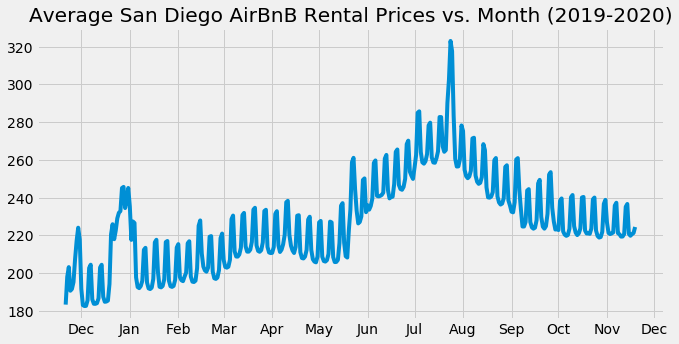

In [47]:
fig = plt.figure(figsize=(10, 5))
months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(months_fmt)
plt.title("Average San Diego AirBnB Rental Prices vs. Month (2019-2020)")

# Create and plot time series
avg_prices = calendar.groupby("date").mean()["price"]
plt.plot(avg_prices.index, avg_prices)
plt.savefig("plots/averagePrice.png")

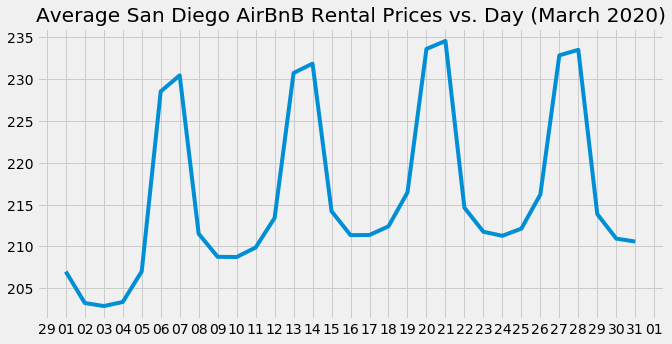

In [48]:
fig = plt.figure(figsize=(10, 5))
days = mdates.DayLocator()
days_fmt = mdates.DateFormatter('%d')
plt.gca().xaxis.set_major_locator(days)
plt.gca().xaxis.set_major_formatter(days_fmt)
avg_prices = calendar.groupby("date").mean()["price"]
plt.title("Average San Diego AirBnB Rental Prices vs. Day (March 2020)")

# Create and plot time series of prices in march
march_prices = avg_prices[avg_prices.index.month == 3]
plt.plot(march_prices.index, march_prices);

plt.savefig("plots/averagePrice.png")

In [54]:
deltas = avg_prices.index - pd.DatetimeIndex([datetime.date(2020, 10, 1) for x in range(len(avg_prices))])
train_part = avg_prices[deltas.days < 0]
test_part = avg_prices[~(deltas.days < 0)]
avg_prices

date
2019-11-21    183.263518
2019-11-22    197.970900
2019-11-23    203.130838
2019-11-24    190.625313
2019-11-25    191.547959
                 ...    
2020-11-15    220.735745
2020-11-16    219.767865
2020-11-17    220.604685
2020-11-18    221.224400
2020-11-19    224.404523
Name: price, Length: 365, dtype: float64

In [52]:
train_part

date
2019-11-21    183.263518
2019-11-22    197.970900
2019-11-23    203.130838
2019-11-24    190.625313
2019-11-25    191.547959
                 ...    
2020-09-26    253.467217
2020-09-27    234.605127
2020-09-28    227.417047
2020-09-29    223.048475
2020-09-30    223.340725
Name: price, Length: 315, dtype: float64

In [75]:
dfPro = pd.DataFrame()
dfPro['y'] = avg_prices
dfPro = dfPro.reset_index().rename(columns = {'date': 'ds'})
dfPro

,ds,y
0,2019-11-21,183.263518
1,2019-11-22,197.970900
2,2019-11-23,203.130838
3,2019-11-24,190.625313
4,2019-11-25,191.547959
...,...,...
360,2020-11-15,220.735745
361,2020-11-16,219.767865
362,2020-11-17,220.604685
363,2020-11-18,221.224400


In [76]:
prophet = Prophet()
prophet.fit(dfPro)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


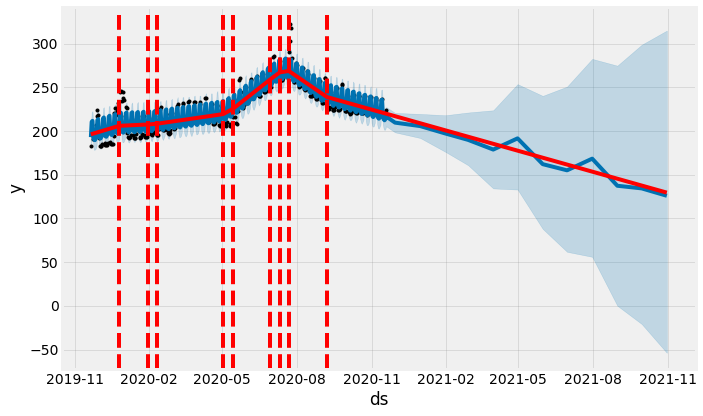

In [88]:
future = prophet.make_future_dataframe(periods= 12, freq='M')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

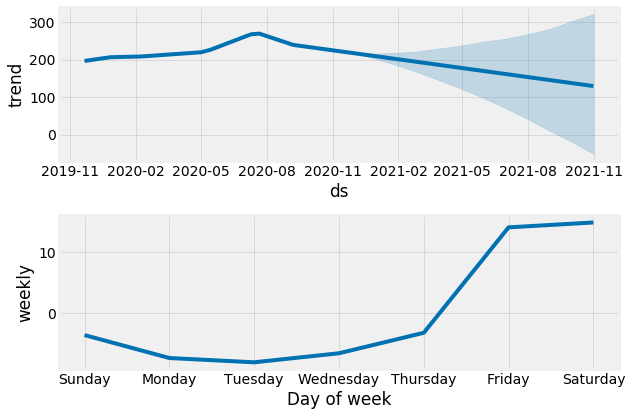

In [91]:
fig2 = prophet.plot_components(forecast)

In [93]:
cross_validation?

In [108]:
df_cv = cross_validation(prophet, initial = '10 days' , horizon = '30 days')
df_cv.head()

INFO:fbprophet:Making 22 forecasts with cutoffs between 2019-12-10 00:00:00 and 2020-10-20 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-11,180.217393,173.202436,187.582727,184.032415,2019-12-10
1,2019-12-12,183.813876,176.357621,191.611091,186.566598,2019-12-10
2,2019-12-13,195.331661,188.257628,202.894075,202.930603,2019-12-10
3,2019-12-14,194.119740,186.543884,201.222549,204.385737,2019-12-10
4,2019-12-15,173.675875,165.937120,181.646791,187.392736,2019-12-10


In [109]:
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
23,26 days,1335.871880,36.549581,27.635820,0.124935,0.091050,0.227273
24,27 days,1428.883913,37.800581,28.688743,0.131151,0.099160,0.212121
25,28 days,1523.851218,39.036537,29.693957,0.136050,0.103789,0.212121
26,29 days,1580.158500,39.751208,30.317584,0.137864,0.106489,0.196970
27,30 days,1614.685476,40.183149,31.035896,0.139113,0.109922,0.181818


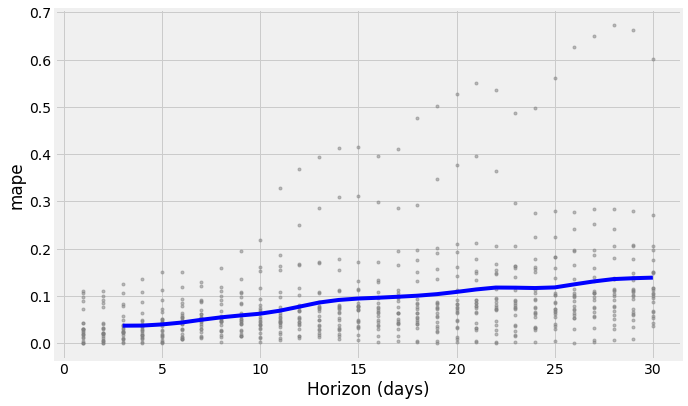

In [110]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
